# Bias in the Entertainment Industry

## Introduction

Implicit bias exists everywhere, and a lot of this can be influenced by media. 

In one finding from UCLA’s college of social sciences, we can see that the number of male leads outweighs the number of female leads by no small amount. The distribution fluctuates slightly, but there is a pretty consistent male domination over lead roles. Considering that women make up roughly 50% of the world’s population, it’s strange that media representation of people’s lives is so skewed towards the male perspective. 

We wanted to take a look at one aspect of how media might affect stereotypes. Specifically, what type of actors or actresses are more likely to play certain genres of film? This may have an impact on how we view these types of people in everyday life, and also shows the biases ingrained in the film industry, which often reflect biases in society as a whole.

## Table of Contents
- [Data Loading](#Data-Loading)
- [Data Processing](#Data-Processing)
- [Data Visualization](#Data-Visualization)
- [Building a Model](#Building-a-Model)
- [Making Predictions](#Making-Predictions)
- [Conclusion](#Conclusion)

Below are the libraries we will be using for this project.

In [151]:
import io, time, json
import requests
from pathlib import Path
from bs4 import BeautifulSoup
import urllib.request
import re

import csv
import gzip
import sqlite3
import pandas as pd
import math

import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib.image as mpimg
import numpy as np
import torch
import os

import string
import time
import tarfile
from PIL import Image
from collections import Counter

from itertools import combinations

if not os.environ.get("DISABLE_TESTING", False):
    %matplotlib inline

## Data Loading
We start by scraping and loading data from an IMDb list of 1000 top actors and actresses, which we felt would give a proper representation of how actors and actresses are distributed across genres.

![Scroll of ](Final/scroll.mov)


To load the data, we used BeautifulSoup to gather information. We scrape the list for the links to each celebrity's personal page. Robert De Niro's personal page and a snippet of the corresponding HTML is shown below:

![pic2](Final/imdbHtml.jpeg)

We first obtain the names of the celebrities, as well as their images shown on the page. Each person's image is saved under his/her name stripped of punctuation and spacing. We store names and images in two lists as a preparation for the pandas dataframe we will be creating.

In [103]:
"""
imgs is a list storing the first 100 images to be displayed.

links is a list storing the links to celebrity's personal page.

names is a list storing the image filenames (stripped of spacings and punctuations).

OGnames is a list storing the names of celebrities.
"""

count = 0
imgs = []
links = []
names = []
OGnames = []

if not os.path.exists('fimages'):
    os.makedirs('fimages')

"""
We loop through each of the 10 pages.
"""
for i in range(1,11):
    print("DOWNLOADING PAGE " + str(i) + "...")
    url = 'https://www.imdb.com/list/ls058011111/?page=' + str(i) 
    html = urllib.request.urlopen(url)
    soup = BeautifulSoup(html,'html.parser')

    """
    Getting links to each actor's page, as well as his/her name.
    """
    
    for header in soup.findAll('h3', {'class':'lister-item-header'}):
        link = header.find('a', href=True)
        newpage = link['href']
        links.append(newpage)
        name = link.text.strip()
        OGnames.append(name)
        name = name.replace(' ','')
        name = name.translate(str.maketrans('','',string.punctuation))
        names.append(name)
    
    """
    Find all images on the current page.
    """
    images = soup.find_all('img',{'src':re.compile('.jpg')})
    
    """
    Below, we download each image as a jpg file under the name of the corresponding celebrity. 
    
    The first 100 images' pixel information is stored in a list so that they can be displayed later.
    """
    for image in images:
        path = os.path.join('fimages/',names[count] + '.jpg')
        f = open (path,'wb')
        f.write(urllib.request.urlopen(image['src']).read())
        f.close()
        
        if count < 100:
            img = Image.open(path)
            imgs.append(img)
        count += 1


DOWNLOADING PAGE 1...
DOWNLOADING PAGE 2...
DOWNLOADING PAGE 3...
DOWNLOADING PAGE 4...
DOWNLOADING PAGE 5...
DOWNLOADING PAGE 6...
DOWNLOADING PAGE 7...
DOWNLOADING PAGE 8...
DOWNLOADING PAGE 9...
DOWNLOADING PAGE 10...


Here, we display the first 100 images. Note that some images were orignally in grayscale but displayed in RGB.

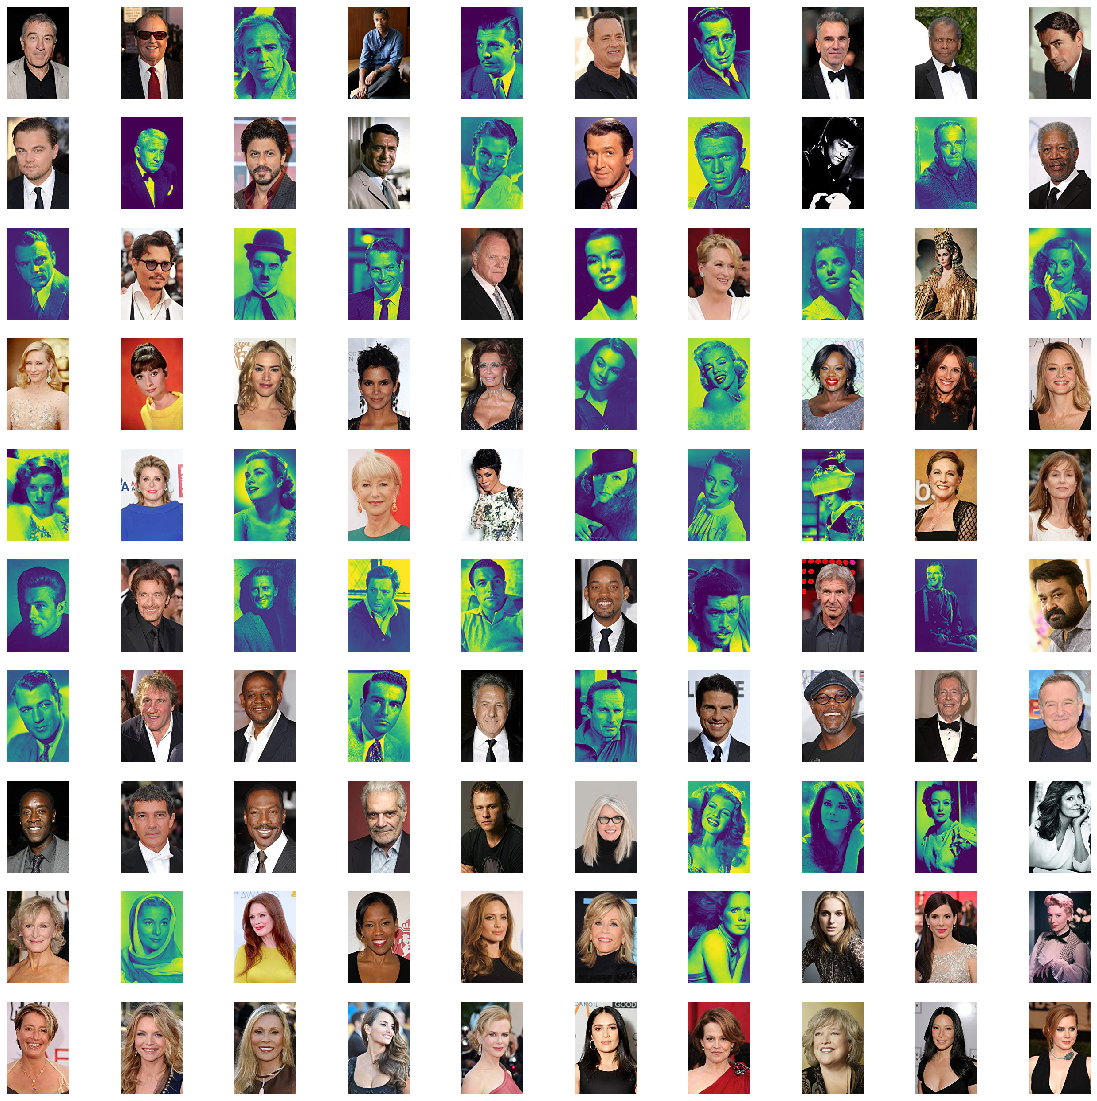

In [100]:
plt.figure(figsize=(20,20))
for i in range(len(imgs)):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(np.asarray(imgs[i]))

Since some of the hometowns of each celebrity on IMDb contains information in brackets about where they now live, we wanted to standardize the format of the hometown. For instance, Gregory Peck's hometown is listed as La Jolla \[now in San Diego\], which we canonicalize to La Jolla. Thus we define the function `canonicalizeHometown` below. This function also processes hometowns such that only the last two comma-separated values of the address information are preserved. We do this so that the hometown information is not overspecific, as it is less practical to categorize based on a particular city than on a state or region.

In [4]:
def canonicalizeHometown (s):
    hometown = re.sub(r' \[[^)]*\]', '', s)
    arr = hometown.split(', ')
    if len(arr) < 2:
        return hometown
    else:
        (state, country) = (arr[len(arr)-2],arr[len(arr)-1])
        hometown = state + ', ' + country
    return hometown


Then, we continue by scraping data from each actor or actress's personal page. We first create a BeautifulSoup object for each page and find the div tag with id `name-born-info`. This tag provides us with information regarding the birth place and birth date of the actor or actress. Noticing that each male had `actor` listed as one of his professions, and each female had `actress` listed as one of her professions, we are also able to obtain the gender of the celebrity.

From each celebrity's page, we then also want links to each of their (up to four) known works listed on IMDb. Following each of the links to the corresponding page, we retrieve the genre for each work, and the release year of the first-listed known work. 

In [5]:
people = list(zip(names,list(zip(OGnames,links))))
people = [{'name':n,'image':i + '.jpg','link':"https://www.imdb.com" + l} for (i,(n,l)) in people]

for person in people:
    """
    Scraping from current person's IMDb page.
    """
    url = person['link']
    html = urllib.request.urlopen(url)
    soup = BeautifulSoup(html,'html.parser')
    
    """
    Obtaining the birth date of the current person.
    """
    header = soup.find('div', {'id':'name-born-info'})
    date = header.find('time')
    bday = date['datetime']
    person['birthday'] = bday

    """
    Finding and canonicalizing the birth place of the person.
    """
    home = header.findAll('a',href = True)[2]
    hometown = home.text.strip()
    person['hometown'] = canonicalizeHometown(hometown)
    
    """
    Find the gender of the person.
    """
    gender = 'N/A'
    r = soup.find('a', {'data-category':'actor'})
    if r != None:
        gender = 'M'
    else:
        r = soup.find('a', {'data-category':'actress'})
        if r != None:
            gender = 'F'

    person['gender'] = gender

    """
    Obtaining the list of links to the known works of the current person,
    and scraping genre information from each of the links.
    """
    knownwork = soup.find('div', {'id':'knownfor'})
    genres = []
    fameDate = 'N/A'
    if(knownwork != None):    
        for title in knownwork.findAll('div', {'class':'knownfor-title'}):
            film = title.find('a', href = True)

            url = "https://www.imdb.com" + film['href']
            html = urllib.request.urlopen(url)
            soup = BeautifulSoup(html,'html.parser')

            subtext = soup.find('div', {'class': 'subtext'})

            for genre in subtext.findAll('a', href = True):
                genres.append(genre.text.strip())

            genres = genres[:-1]
            
        firstWork = knownwork.find('div',{'class': 'knownfor-title'})
        fameYr = firstWork.find('div',{'class':'knownfor-year'})
        fameDate = fameYr.find('span', {'class':'knownfor-ellipsis'})
        fameDate = fameDate.text[1:-1]
    
    person['peakYear'] = fameDate
    
    """
    We store the genres of each actor/actress's known works in a dictionary, 
    with the genre as the key and number of works in that genre as value
    """
    person['genres'] = Counter(genres)
    
    print(person)
    

{'name': 'Robert De Niro', 'image': 'RobertDeNiro.jpg', 'link': 'https://www.imdb.com/name/nm0000134', 'birthday': '1943-8-17', 'hometown': 'New York, USA', 'gender': 'M', 'peakYear': '1980', 'genres': Counter({'Drama': 3, 'Crime': 3, 'Thriller': 2, 'Biography': 1, 'Sport': 1})}
{'name': 'Jack Nicholson', 'image': 'JackNicholson.jpg', 'link': 'https://www.imdb.com/name/nm0000197', 'birthday': '1937-4-22', 'hometown': 'New Jersey, USA', 'gender': 'M', 'peakYear': '1974', 'genres': Counter({'Drama': 4, 'Thriller': 2, 'Mystery': 1, 'Comedy': 1, 'Romance': 1, 'Crime': 1})}
{'name': 'Marlon Brando', 'image': 'MarlonBrando.jpg', 'link': 'https://www.imdb.com/name/nm0000008', 'birthday': '1924-4-3', 'hometown': 'Nebraska, USA', 'gender': 'M', 'peakYear': '1979', 'genres': Counter({'Drama': 4, 'Mystery': 1, 'War': 1, 'Crime': 1, 'Romance': 1})}
{'name': 'Denzel Washington', 'image': 'DenzelWashington.jpg', 'link': 'https://www.imdb.com/name/nm0000243', 'birthday': '1954-12-28', 'hometown': 'Ne

{'name': 'Bette Davis', 'image': 'BetteDavis.jpg', 'link': 'https://www.imdb.com/name/nm0000012', 'birthday': '1908-4-5', 'hometown': 'Massachusetts, USA', 'gender': 'F', 'peakYear': '1950', 'genres': Counter({'Drama': 4, 'Romance': 2, 'Horror': 1, 'Thriller': 1})}
{'name': 'Cate Blanchett', 'image': 'CateBlanchett.jpg', 'link': 'https://www.imdb.com/name/nm0000949', 'birthday': '1969-5-14', 'hometown': 'Victoria, Australia', 'gender': 'F', 'peakYear': '2015', 'genres': Counter({'Drama': 4, 'Biography': 2, 'Romance': 1, 'History': 1})}
{'name': 'Audrey Hepburn', 'image': 'AudreyHepburn.jpg', 'link': 'https://www.imdb.com/name/nm0000030', 'birthday': '1929-5-4', 'hometown': 'Brussels, Belgium', 'gender': 'F', 'peakYear': '1961', 'genres': Counter({'Comedy': 3, 'Romance': 3, 'Drama': 2, 'Mystery': 1, 'Family': 1, 'Musical': 1})}
{'name': 'Kate Winslet', 'image': 'KateWinslet.jpg', 'link': 'https://www.imdb.com/name/nm0000701', 'birthday': '1975-10-5', 'hometown': 'England, UK', 'gender':

{'name': 'John Wayne', 'image': 'JohnWayne.jpg', 'link': 'https://www.imdb.com/name/nm0000078', 'birthday': '1907-5-26', 'hometown': 'Iowa, USA', 'gender': 'M', 'peakYear': '1969', 'genres': Counter({'Drama': 3, 'Western': 3, 'Adventure': 2, 'History': 1, 'Comedy': 1, 'Romance': 1})}
{'name': 'Mohanlal', 'image': 'Mohanlal.jpg', 'link': 'https://www.imdb.com/name/nm0482320', 'birthday': '1960-5-21', 'hometown': 'Kerala, India', 'gender': 'M', 'peakYear': '1989', 'genres': Counter({'Drama': 3, 'Action': 3, 'Comedy': 1, 'Thriller': 1})}
{'name': 'Gary Cooper', 'image': 'GaryCooper.jpg', 'link': 'https://www.imdb.com/name/nm0000011', 'birthday': '1901-5-7', 'hometown': 'Montana, USA', 'gender': 'M', 'peakYear': '1952', 'genres': Counter({'Drama': 4, 'History': 2, 'Thriller': 1, 'Western': 1, 'Biography': 1, 'Comedy': 1, 'Romance': 1, 'Adventure': 1})}
{'name': 'Gérard Depardieu', 'image': 'GérardDepardieu.jpg', 'link': 'https://www.imdb.com/name/nm0000367', 'birthday': '1948-12-27', 'home

{'name': 'Liv Ullmann', 'image': 'LivUllmann.jpg', 'link': 'https://www.imdb.com/name/nm0880521', 'birthday': '1938-12-16', 'hometown': 'Tokyo, Japan', 'gender': 'F', 'peakYear': '1972', 'genres': Counter({'Drama': 4, 'Fantasy': 1, 'Thriller': 1, 'History': 1})}
{'name': 'Natalie Portman', 'image': 'NataliePortman.jpg', 'link': 'https://www.imdb.com/name/nm0000204', 'birthday': '1981-6-9', 'hometown': 'Jerusalem, Israel', 'gender': 'F', 'peakYear': '2010', 'genres': Counter({'Drama': 4, 'Thriller': 1, 'Action': 1, 'Sci-Fi': 1, 'Romance': 1, 'Biography': 1, 'History': 1})}
{'name': 'Sandra Bullock', 'image': 'SandraBullock.jpg', 'link': 'https://www.imdb.com/name/nm0000113', 'birthday': '1964-7-26', 'hometown': 'Virginia, USA', 'gender': 'F', 'peakYear': '2009', 'genres': Counter({'Comedy': 2, 'Drama': 2, 'Action': 2, 'Thriller': 2, 'Romance': 1, 'Crime': 1, 'Sci-Fi': 1, 'Adventure': 1})}
{'name': 'Deborah Kerr', 'image': 'DeborahKerr.jpg', 'link': 'https://www.imdb.com/name/nm0000039',

{'name': 'Ian McKellen', 'image': 'IanMcKellen.jpg', 'link': 'https://www.imdb.com/name/nm0005212', 'birthday': '1939-5-25', 'hometown': 'England, UK', 'gender': 'M', 'peakYear': '2001', 'genres': Counter({'Drama': 4, 'Adventure': 3, 'Fantasy': 3, 'Biography': 1})}
{'name': 'Russell Crowe', 'image': 'RussellCrowe.jpg', 'link': 'https://www.imdb.com/name/nm0000128', 'birthday': '1964-4-7', 'hometown': 'Wellington, New Zealand', 'gender': 'M', 'peakYear': '2012', 'genres': Counter({'Drama': 4, 'History': 1, 'Musical': 1, 'Action': 1, 'Adventure': 1, 'Biography': 1, 'Crime': 1, 'Mystery': 1})}
{'name': 'Bill Murray', 'image': 'BillMurray.jpg', 'link': 'https://www.imdb.com/name/nm0000195', 'birthday': '1950-9-21', 'hometown': 'Illinois, USA', 'gender': 'M', 'peakYear': '2003', 'genres': Counter({'Drama': 3, 'Comedy': 3, 'Romance': 1, 'Action': 1, 'Adventure': 1})}
{'name': 'Nicolas Cage', 'image': 'NicolasCage.jpg', 'link': 'https://www.imdb.com/name/nm0000115', 'birthday': '1964-1-7', 'h

{'name': 'Kim Basinger', 'image': 'KimBasinger.jpg', 'link': 'https://www.imdb.com/name/nm0000107', 'birthday': '1953-12-8', 'hometown': 'Georgia, USA', 'gender': 'F', 'peakYear': '1997', 'genres': Counter({'Crime': 2, 'Action': 2, 'Drama': 1, 'Mystery': 1, 'Adventure': 1, 'Thriller': 1, 'Comedy': 1, 'Music': 1})}
{'name': 'Glenda Jackson', 'image': 'GlendaJackson.jpg', 'link': 'https://www.imdb.com/name/nm0413559', 'birthday': '1936-5-9', 'hometown': 'England, UK', 'gender': 'F', 'peakYear': '1969', 'genres': Counter({'Drama': 3, 'Romance': 2, 'Comedy': 1, 'Biography': 1, 'History': 1})}
{'name': 'Donna Reed', 'image': 'DonnaReed.jpg', 'link': 'https://www.imdb.com/name/nm0001656', 'birthday': '1921-1-27', 'hometown': 'Iowa, USA', 'gender': 'F', 'peakYear': '1946', 'genres': Counter({'Drama': 3, 'Family': 2, 'Romance': 2, 'Fantasy': 1, 'War': 1, 'Comedy': 1})}
{'name': 'Demi Moore', 'image': 'DemiMoore.jpg', 'link': 'https://www.imdb.com/name/nm0000193', 'birthday': '1962-11-11', 'hom

{'name': 'Ed Harris', 'image': 'EdHarris.jpg', 'link': 'https://www.imdb.com/name/nm0000438', 'birthday': '1950-11-28', 'hometown': 'New Jersey, USA', 'gender': 'M', 'peakYear': '1998', 'genres': Counter({'Drama': 4, 'Comedy': 1, 'Sci-Fi': 1, 'Action': 1, 'Crime': 1, 'Biography': 1, 'Adventure': 1, 'History': 1})}
{'name': 'Harvey Keitel', 'image': 'HarveyKeitel.jpg', 'link': 'https://www.imdb.com/name/nm0000172', 'birthday': '1939-5-13', 'hometown': 'New York, USA', 'gender': 'M', 'peakYear': '1992', 'genres': Counter({'Crime': 4, 'Drama': 3, 'Thriller': 2, 'Adventure': 1, 'Comedy': 1})}
{'name': 'Jon Voight', 'image': 'JonVoight.jpg', 'link': 'https://www.imdb.com/name/nm0000685', 'birthday': '1938-12-29', 'hometown': 'New York, USA', 'gender': 'M', 'peakYear': '1969', 'genres': Counter({'Adventure': 3, 'Drama': 2, 'Action': 2, 'Western': 1, 'Horror': 1, 'Thriller': 1, 'Sci-Fi': 1})}
{'name': 'Drew Barrymore', 'image': 'DrewBarrymore.jpg', 'link': 'https://www.imdb.com/name/nm0000106

{'name': 'Kevin Bacon', 'image': 'KevinBacon.jpg', 'link': 'https://www.imdb.com/name/nm0000102', 'birthday': '1958-7-8', 'hometown': 'Pennsylvania, USA', 'gender': 'M', 'peakYear': '1984', 'genres': Counter({'Drama': 3, 'Music': 1, 'Romance': 1, 'Action': 1, 'Horror': 1, 'Sci-Fi': 1, 'Crime': 1, 'Mystery': 1})}
{'name': 'Patrick Swayze', 'image': 'PatrickSwayze.jpg', 'link': 'https://www.imdb.com/name/nm0000664', 'birthday': '1952-8-18', 'hometown': 'Texas, USA', 'gender': 'M', 'peakYear': '1987', 'genres': Counter({'Drama': 2, 'Romance': 2, 'Action': 2, 'Thriller': 2, 'Music': 1, 'Crime': 1, 'Fantasy': 1})}
{'name': 'Michael Caine', 'image': 'MichaelCaine.jpg', 'link': 'https://www.imdb.com/name/nm0000323', 'birthday': '1933-3-14', 'hometown': 'England, UK', 'gender': 'M', 'peakYear': '2006', 'genres': Counter({'Drama': 4, 'Romance': 2, 'Mystery': 1, 'Sci-Fi': 1, 'Action': 1, 'Crime': 1, 'Thriller': 1})}
{'name': 'Robert Duvall', 'image': 'RobertDuvall.jpg', 'link': 'https://www.imdb

{'name': 'Carmen Miranda', 'image': 'CarmenMiranda.jpg', 'link': 'https://www.imdb.com/name/nm0000544', 'birthday': '1909-2-9', 'hometown': 'Marco de Canavezes, Portugal', 'gender': 'F', 'peakYear': '1943', 'genres': Counter({'Musical': 4, 'Comedy': 3, 'Romance': 1})}
{'name': 'Kate Hudson', 'image': 'KateHudson.jpg', 'link': 'https://www.imdb.com/name/nm0005028', 'birthday': '1979-4-19', 'hometown': 'California, USA', 'gender': 'F', 'peakYear': '2000', 'genres': Counter({'Comedy': 4, 'Adventure': 2, 'Romance': 2, 'Drama': 1, 'Action': 1})}
{'name': 'Catherine Zeta-Jones', 'image': 'CatherineZetaJones.jpg', 'link': 'https://www.imdb.com/name/nm0001876', 'birthday': '1969-9-25', 'hometown': 'Wales, UK', 'gender': 'F', 'peakYear': '2002', 'genres': Counter({'Crime': 3, 'Comedy': 2, 'Action': 2, 'Musical': 1, 'Drama': 1, 'Thriller': 1, 'Adventure': 1, 'Romance': 1})}
{'name': 'Cameron Diaz', 'image': 'CameronDiaz.jpg', 'link': 'https://www.imdb.com/name/nm0000139', 'birthday': '1972-8-30'

{'name': 'Jeremy Irons', 'image': 'JeremyIrons.jpg', 'link': 'https://www.imdb.com/name/nm0000460', 'birthday': '1948-9-19', 'hometown': 'England, UK', 'gender': 'M', 'peakYear': '1988', 'genres': Counter({'Drama': 3, 'Adventure': 2, 'Horror': 1, 'Thriller': 1, 'Animation': 1, 'Action': 1, 'Sci-Fi': 1, 'Romance': 1})}
{'name': 'F. Murray Abraham', 'image': 'FMurrayAbraham.jpg', 'link': 'https://www.imdb.com/name/nm0000719', 'birthday': '1939-10-24', 'hometown': 'Pennsylvania, USA', 'gender': 'M', 'peakYear': '2014', 'genres': Counter({'Adventure': 2, 'Comedy': 2, 'Crime': 1, 'Biography': 1, 'Drama': 1, 'History': 1, 'Fantasy': 1, 'Romance': 1, 'Action': 1, 'Sci-Fi': 1})}
{'name': 'Richard Dreyfuss', 'image': 'RichardDreyfuss.jpg', 'link': 'https://www.imdb.com/name/nm0000377', 'birthday': '1947-10-29', 'hometown': 'New York, USA', 'gender': 'M', 'peakYear': '1977', 'genres': Counter({'Drama': 4, 'Comedy': 2, 'Romance': 1, 'Adventure': 1, 'Thriller': 1, 'Sci-Fi': 1})}
{'name': 'Peter Fi

{'name': 'Rachel McAdams', 'image': 'RachelMcAdams.jpg', 'link': 'https://www.imdb.com/name/nm1046097', 'birthday': '1978-11-17', 'hometown': 'Ontario, Canada', 'gender': 'F', 'peakYear': '2004', 'genres': Counter({'Drama': 2, 'Romance': 2, 'Comedy': 1, 'Action': 1, 'Mystery': 1, 'Thriller': 1})}
{'name': 'Carey Mulligan', 'image': 'CareyMulligan.jpg', 'link': 'https://www.imdb.com/name/nm1659547', 'birthday': '1985-5-28', 'hometown': 'England, UK', 'gender': 'F', 'peakYear': '2010', 'genres': Counter({'Drama': 4, 'Romance': 1, 'Sci-Fi': 1, 'Biography': 1, 'History': 1})}
{'name': 'Mila Kunis', 'image': 'MilaKunis.jpg', 'link': 'https://www.imdb.com/name/nm0005109', 'birthday': '1983-8-14', 'hometown': 'Ukrainian SSR, USSR', 'gender': 'F', 'peakYear': '2010', 'genres': Counter({'Drama': 2, 'Comedy': 2, 'Thriller': 1, 'Action': 1, 'Adventure': 1, 'Sci-Fi': 1, 'Romance': 1})}
{'name': 'Amanda Seyfried', 'image': 'AmandaSeyfried.jpg', 'link': 'https://www.imdb.com/name/nm1086543', 'birthd

{'name': 'Chris Hemsworth', 'image': 'ChrisHemsworth.jpg', 'link': 'https://www.imdb.com/name/nm1165110', 'birthday': '1983-8-11', 'hometown': 'Victoria, Australia', 'gender': 'M', 'peakYear': '2012', 'genres': Counter({'Action': 4, 'Adventure': 4, 'Sci-Fi': 1, 'Comedy': 1, 'Drama': 1, 'Fantasy': 1})}
{'name': 'Warner Baxter', 'image': 'WarnerBaxter.jpg', 'link': 'https://www.imdb.com/name/nm0062828', 'birthday': '1889-3-29', 'hometown': 'Ohio, USA', 'gender': 'M', 'peakYear': '1933', 'genres': Counter({'Romance': 3, 'Comedy': 2, 'Musical': 2, 'Crime': 1, 'Mystery': 1, 'Western': 1})}
{'name': 'Emil Jannings', 'image': 'EmilJannings.jpg', 'link': 'https://www.imdb.com/name/nm0417837', 'birthday': '1884-7-23', 'hometown': 'St. Gallen, Switzerland', 'gender': 'M', 'peakYear': '1928', 'genres': Counter({'Drama': 3, 'History': 1, 'Romance': 1, 'Comedy': 1, 'Fantasy': 1, 'Horror': 1})}
{'name': 'Chris Cooper', 'image': 'ChrisCooper.jpg', 'link': 'https://www.imdb.com/name/nm0177933', 'birth

{'name': 'Shirley Temple', 'image': 'ShirleyTemple.jpg', 'link': 'https://www.imdb.com/name/nm0000073', 'birthday': '1928-4-23', 'hometown': 'California, USA', 'gender': 'F', 'peakYear': '1936', 'genres': Counter({'Comedy': 3, 'Family': 3, 'Musical': 2, 'Adventure': 2, 'Action': 1, 'Western': 1})}
{'name': 'Julia Louis-Dreyfus', 'image': 'JuliaLouisDreyfus.jpg', 'link': 'https://www.imdb.com/name/nm0000506', 'birthday': '1961-1-13', 'hometown': 'New York, USA', 'gender': 'F', 'peakYear': '1990-1998', 'genres': Counter({'Comedy': 4, 'Drama': 1, 'Romance': 1})}
{'name': 'Olivia Thirlby', 'image': 'OliviaThirlby.jpg', 'link': 'https://www.imdb.com/name/nm1880888', 'birthday': '1986-10-6', 'hometown': 'New York, USA', 'gender': 'F', 'peakYear': '2007', 'genres': Counter({'Comedy': 3, 'Drama': 2, 'Romance': 2, 'Action': 1, 'Crime': 1, 'Sci-Fi': 1})}
{'name': 'Cher', 'image': 'Cher.jpg', 'link': 'https://www.imdb.com/name/nm0000333', 'birthday': '1946-5-20', 'hometown': 'California, USA', 'g

{'name': 'Red Buttons', 'image': 'RedButtons.jpg', 'link': 'https://www.imdb.com/name/nm0000999', 'birthday': '1919-2-5', 'hometown': 'New York, USA', 'gender': 'M', 'peakYear': '1972', 'genres': Counter({'Drama': 3, 'Action': 2, 'Adventure': 2, 'Romance': 1, 'History': 1, 'Animation': 1, 'Comedy': 1})}
{'name': "Edmond O'Brien", 'image': 'EdmondOBrien.jpg', 'link': 'https://www.imdb.com/name/nm0639529', 'birthday': '1915-9-10', 'hometown': 'New York, USA', 'gender': 'M', 'peakYear': '1962', 'genres': Counter({'Drama': 4, 'Crime': 2, 'Western': 1, 'Thriller': 1, 'Mystery': 1, 'Action': 1})}
{'name': 'Chris Pratt', 'image': 'ChrisPratt.jpg', 'link': 'https://www.imdb.com/name/nm0695435', 'birthday': '1979-6-21', 'hometown': 'Minnesota, USA', 'gender': 'M', 'peakYear': '2014', 'genres': Counter({'Action': 3, 'Adventure': 3, 'Comedy': 2, 'Animation': 1, 'Sci-Fi': 1})}
{'name': 'Frank Sinatra', 'image': 'FrankSinatra.jpg', 'link': 'https://www.imdb.com/name/nm0000069', 'birthday': '1915-12

{'name': 'Jean Reno', 'image': 'JeanReno.jpg', 'link': 'https://www.imdb.com/name/nm0000606', 'birthday': '1948-7-30', 'hometown': 'Casablanca, French Protectorate of Morocco', 'gender': 'M', 'peakYear': '1994', 'genres': Counter({'Action': 3, 'Drama': 3, 'Crime': 2, 'Adventure': 1, 'Sport': 1, 'Thriller': 1, 'Comedy': 1})}
{'name': 'George Sanders', 'image': 'GeorgeSanders.jpg', 'link': 'https://www.imdb.com/name/nm0001695', 'birthday': '1906-7-3', 'hometown': 'St. Petersburg, Russian Empire', 'gender': 'M', 'peakYear': '1950', 'genres': Counter({'Drama': 3, 'Mystery': 1, 'Romance': 1, 'Fantasy': 1, 'Horror': 1, 'Animation': 1, 'Adventure': 1, 'Family': 1})}
{'name': 'Dean Jagger', 'image': 'DeanJagger.jpg', 'link': 'https://www.imdb.com/name/nm0415591', 'birthday': '1903-11-7', 'hometown': 'Ohio, USA', 'gender': 'M', 'peakYear': '1954', 'genres': Counter({'Drama': 2, 'Action': 2, 'Crime': 2, 'Comedy': 1, 'Musical': 1, 'Romance': 1, 'War': 1, 'Thriller': 1})}
{'name': 'Walter Huston',

{'name': 'Maureen Stapleton', 'image': 'MaureenStapleton.jpg', 'link': 'https://www.imdb.com/name/nm0822972', 'birthday': '1925-6-21', 'hometown': 'New York, USA', 'gender': 'F', 'peakYear': '1981', 'genres': Counter({'Drama': 4, 'Biography': 1, 'History': 1, 'Action': 1, 'Thriller': 1, 'Comedy': 1, 'Sci-Fi': 1})}
{'name': 'Mary Steenburgen', 'image': 'MarySteenburgen.jpg', 'link': 'https://www.imdb.com/name/nm0005460', 'birthday': '1953-2-8', 'hometown': 'Arkansas, USA', 'gender': 'F', 'peakYear': '2013', 'genres': Counter({'Comedy': 3, 'Drama': 2, 'Adventure': 2, 'Sci-Fi': 2})}
{'name': 'Beatrice Straight', 'image': 'BeatriceStraight.jpg', 'link': 'https://www.imdb.com/name/nm0833152', 'birthday': '1914-8-2', 'hometown': 'New York, USA', 'gender': 'F', 'peakYear': '1976', 'genres': Counter({'Drama': 3, 'Horror': 1, 'Thriller': 1, 'Crime': 1, 'Mystery': 1})}
{'name': 'Vanessa Redgrave', 'image': 'VanessaRedgrave.jpg', 'link': 'https://www.imdb.com/name/nm0000603', 'birthday': '1937-1-

{'name': 'Chris Evans', 'image': 'ChrisEvans.jpg', 'link': 'https://www.imdb.com/name/nm0262635', 'birthday': '1981-6-13', 'hometown': 'Massachusetts, USA', 'gender': 'M', 'peakYear': '2012', 'genres': Counter({'Action': 4, 'Adventure': 4, 'Sci-Fi': 4})}
{'name': 'James Franco', 'image': 'JamesFranco.jpg', 'link': 'https://www.imdb.com/name/nm0290556', 'birthday': '1978-4-19', 'hometown': 'California, USA', 'gender': 'M', 'peakYear': '2010', 'genres': Counter({'Drama': 3, 'Biography': 2, 'Comedy': 2, 'Crime': 2, 'Action': 1})}
{'name': 'Zach Galifianakis', 'image': 'ZachGalifianakis.jpg', 'link': 'https://www.imdb.com/name/nm0302108', 'birthday': '1969-10-1', 'hometown': 'North Carolina, USA', 'gender': 'M', 'peakYear': '2009', 'genres': Counter({'Comedy': 4, 'Drama': 2})}
{'name': 'Will Ferrell', 'image': 'WillFerrell.jpg', 'link': 'https://www.imdb.com/name/nm0002071', 'birthday': '1967-7-16', 'hometown': 'California, USA', 'gender': 'M', 'peakYear': '2006', 'genres': Counter({'Comed

{'name': 'Alicia Vikander', 'image': 'AliciaVikander.jpg', 'link': 'https://www.imdb.com/name/nm2539953', 'birthday': '1988-10-3', 'hometown': 'Västra Götalands län, Sweden', 'gender': 'F', 'peakYear': '2014', 'genres': Counter({'Drama': 2, 'Action': 2, 'Adventure': 2, 'Mystery': 1, 'Sci-Fi': 1, 'Biography': 1, 'Romance': 1, 'Comedy': 1, 'Fantasy': 1})}
{'name': 'Mia Wasikowska', 'image': 'MiaWasikowska.jpg', 'link': 'https://www.imdb.com/name/nm1985859', 'birthday': '1989-10-25', 'hometown': 'Australian Capital Territory, Australia', 'gender': 'F', 'peakYear': '2010', 'genres': Counter({'Drama': 3, 'Fantasy': 2, 'Adventure': 1, 'Family': 1, 'Thriller': 1, 'Horror': 1, 'Comedy': 1, 'Romance': 1})}
{'name': 'Abigail Breslin', 'image': 'AbigailBreslin.jpg', 'link': 'https://www.imdb.com/name/nm1113550', 'birthday': '1996-4-14', 'hometown': 'New York, USA', 'gender': 'F', 'peakYear': '2006', 'genres': Counter({'Drama': 4, 'Comedy': 3, 'Romance': 1, 'Mystery': 1, 'Sci-Fi': 1})}
{'name': 'G

{'name': 'Edward Norton', 'image': 'EdwardNorton.jpg', 'link': 'https://www.imdb.com/name/nm0001570', 'birthday': '1969-8-18', 'hometown': 'Massachusetts, USA', 'gender': 'M', 'peakYear': '2000', 'genres': Counter({'Drama': 4, 'Comedy': 2, 'Romance': 1, 'Crime': 1, 'Mystery': 1})}
{'name': 'Guy Pearce', 'image': 'GuyPearce.jpg', 'link': 'https://www.imdb.com/name/nm0001602', 'birthday': '1967-10-5', 'hometown': 'England, UK', 'gender': 'M', 'peakYear': '2000', 'genres': Counter({'Mystery': 2, 'Thriller': 2, 'Crime': 2, 'Drama': 2, 'Action': 1, 'Sci-Fi': 1})}
{'name': 'Mark Ruffalo', 'image': 'MarkRuffalo.jpg', 'link': 'https://www.imdb.com/name/nm0749263', 'birthday': '1967-11-22', 'hometown': 'Wisconsin, USA', 'gender': 'M', 'peakYear': '2010', 'genres': Counter({'Drama': 3, 'Biography': 2, 'Comedy': 1, 'Romance': 1, 'Action': 1, 'Adventure': 1, 'Sci-Fi': 1, 'Crime': 1, 'Sport': 1})}
{'name': 'Mickey Rourke', 'image': 'MickeyRourke.jpg', 'link': 'https://www.imdb.com/name/nm0000620', 

{'name': 'Julianne Hough', 'image': 'JulianneHough.jpg', 'link': 'https://www.imdb.com/name/nm2584600', 'birthday': '1988-7-20', 'hometown': 'Utah, USA', 'gender': 'F', 'peakYear': '2012', 'genres': Counter({'Comedy': 3, 'Drama': 3, 'Musical': 1, 'Romance': 1, 'Thriller': 1, 'Music': 1})}
{'name': 'Lily Collins', 'image': 'LilyCollins.jpg', 'link': 'https://www.imdb.com/name/nm2934314', 'birthday': '1989-3-18', 'hometown': 'England, UK', 'gender': 'F', 'peakYear': '2013', 'genres': Counter({'Action': 2, 'Comedy': 2, 'Fantasy': 1, 'Horror': 1, 'Romance': 1, 'Adventure': 1, 'Drama': 1, 'Mystery': 1, 'Thriller': 1})}
{'name': 'Cobie Smulders', 'image': 'CobieSmulders.jpg', 'link': 'https://www.imdb.com/name/nm1130627', 'birthday': '1982-4-3', 'hometown': 'British Columbia, Canada', 'gender': 'F', 'peakYear': '2012', 'genres': Counter({'Action': 3, 'Adventure': 2, 'Sci-Fi': 2, 'Thriller': 2, 'Drama': 1, 'Romance': 1})}
{'name': 'Alice Eve', 'image': 'AliceEve.jpg', 'link': 'https://www.imd

{'name': 'James Garner', 'image': 'JamesGarner.jpg', 'link': 'https://www.imdb.com/name/nm0001258', 'birthday': '1928-4-7', 'hometown': 'Oklahoma, USA', 'gender': 'M', 'peakYear': '2004', 'genres': Counter({'Drama': 3, 'Adventure': 2, 'Romance': 1, 'History': 1, 'Crime': 1, 'Mystery': 1, 'Action': 1, 'Thriller': 1})}
{'name': 'Sam Waterston', 'image': 'SamWaterston.jpg', 'link': 'https://www.imdb.com/name/nm0001832', 'birthday': '1940-11-15', 'hometown': 'Massachusetts, USA', 'gender': 'M', 'peakYear': '1994-2010', 'genres': Counter({'Drama': 3, 'Crime': 2, 'Mystery': 1, 'Biography': 1, 'History': 1, 'Comedy': 1, 'Thriller': 1, 'Romance': 1})}
{'name': 'Tom Hulce', 'image': 'TomHulce.jpg', 'link': 'https://www.imdb.com/name/nm0001371', 'birthday': '1953-12-6', 'hometown': 'Michigan, USA', 'gender': 'M', 'peakYear': '1984', 'genres': Counter({'Drama': 3, 'Comedy': 2, 'Biography': 1, 'History': 1, 'Animation': 1, 'Family': 1})}
{'name': 'Albert Finney', 'image': 'AlbertFinney.jpg', 'link

{'name': 'Mélanie Laurent', 'image': 'MélanieLaurent.jpg', 'link': 'https://www.imdb.com/name/nm0491259', 'birthday': '1983-2-21', 'hometown': 'Paris, France', 'gender': 'F', 'peakYear': '2009', 'genres': Counter({'Drama': 3, 'Adventure': 1, 'War': 1, 'Comedy': 1, 'Romance': 1, 'Crime': 1, 'Mystery': 1, 'Thriller': 1})}
{'name': 'Whitney Houston', 'image': 'WhitneyHouston.jpg', 'link': 'https://www.imdb.com/name/nm0001365', 'birthday': '1963-8-9', 'hometown': 'New Jersey, USA', 'gender': 'F', 'peakYear': '1992', 'genres': Counter({'Drama': 4, 'Music': 2, 'Romance': 2, 'Comedy': 2, 'Fantasy': 1})}
{'name': 'Felicity Huffman', 'image': 'FelicityHuffman.jpg', 'link': 'https://www.imdb.com/name/nm0005031', 'birthday': '1962-12-9', 'hometown': 'New York, USA', 'gender': 'F', 'peakYear': '2005', 'genres': Counter({'Comedy': 3, 'Drama': 3, 'Adventure': 2, 'Mystery': 1, 'Sport': 1, 'Action': 1})}
{'name': 'Imelda Staunton', 'image': 'ImeldaStaunton.jpg', 'link': 'https://www.imdb.com/name/nm00

{'name': 'Ryan Phillippe', 'image': 'RyanPhillippe.jpg', 'link': 'https://www.imdb.com/name/nm0000202', 'birthday': '1974-9-10', 'hometown': 'Delaware, USA', 'gender': 'M', 'peakYear': '2004', 'genres': Counter({'Drama': 4, 'Crime': 2, 'Thriller': 1, 'Comedy': 1, 'Mystery': 1, 'Romance': 1, 'Action': 1})}
{'name': 'Kerry Washington', 'image': 'KerryWashington.jpg', 'link': 'https://www.imdb.com/name/nm0913488', 'birthday': '1977-1-31', 'hometown': 'New York, USA', 'gender': 'F', 'peakYear': '2012', 'genres': Counter({'Drama': 4, 'Western': 1, 'Thriller': 1, 'Music': 1, 'Romance': 1, 'Biography': 1, 'History': 1})}
{'name': 'Carrie-Anne Moss', 'image': 'CarrieAnneMoss.jpg', 'link': 'https://www.imdb.com/name/nm0005251', 'birthday': '1967-8-21', 'hometown': 'British Columbia, Canada', 'gender': 'F', 'peakYear': '1999', 'genres': Counter({'Action': 2, 'Sci-Fi': 2, 'Mystery': 1, 'Thriller': 1, 'Comedy': 1, 'Drama': 1, 'Horror': 1})}
{'name': 'Janet Leigh', 'image': 'JanetLeigh.jpg', 'link'

{'name': 'John Travolta', 'image': 'JohnTravolta.jpg', 'link': 'https://www.imdb.com/name/nm0000237', 'birthday': '1954-2-18', 'hometown': 'New Jersey, USA', 'gender': 'M', 'peakYear': '1994', 'genres': Counter({'Crime': 2, 'Drama': 2, 'Comedy': 1, 'Thriller': 1, 'Musical': 1, 'Romance': 1, 'Music': 1})}
{'name': 'Yun-Fat Chow', 'image': 'YunFatChow.jpg', 'link': 'https://www.imdb.com/name/nm0000334', 'birthday': '1955-5-18', 'hometown': 'Lamma Island, Hong Kong', 'gender': 'M', 'peakYear': '2000', 'genres': Counter({'Action': 4, 'Adventure': 2, 'Fantasy': 2, 'Crime': 1, 'Thriller': 1, 'Drama': 1, 'Romance': 1})}
{'name': 'Seth MacFarlane', 'image': 'SethMacFarlane.jpg', 'link': 'https://www.imdb.com/name/nm0532235', 'birthday': '1973-10-26', 'hometown': 'Connecticut, USA', 'gender': 'M', 'peakYear': '1999-2020', 'genres': Counter({'Comedy': 4, 'Animation': 2, 'Western': 1})}
{'name': 'Jet Li', 'image': 'JetLi.jpg', 'link': 'https://www.imdb.com/name/nm0001472', 'birthday': '1963-4-26'

{'name': 'Taraji P. Henson', 'image': 'TarajiPHenson.jpg', 'link': 'https://www.imdb.com/name/nm0378245', 'birthday': '1970-9-11', 'hometown': 'District of Columbia, USA', 'gender': 'F', 'peakYear': '2008', 'genres': Counter({'Drama': 4, 'Fantasy': 1, 'Romance': 1, 'Biography': 1, 'History': 1, 'Crime': 1, 'Music': 1, 'Action': 1, 'Family': 1})}
{'name': 'Amy Ryan', 'image': 'AmyRyan.jpg', 'link': 'https://www.imdb.com/name/nm0752407', 'birthday': '1968-5-3', 'hometown': 'New York, USA', 'gender': 'F', 'peakYear': '2014', 'genres': Counter({'Drama': 4, 'Comedy': 2, 'Crime': 2, 'Mystery': 1, 'Sport': 1, 'Thriller': 1})}
{'name': 'Ruby Dee', 'image': 'RubyDee.jpg', 'link': 'https://www.imdb.com/name/nm0002039', 'birthday': '1922-10-27', 'hometown': 'Ohio, USA', 'gender': 'F', 'peakYear': '2007', 'genres': Counter({'Drama': 4, 'Biography': 1, 'Crime': 1, 'Comedy': 1, 'Romance': 1})}
{'name': 'Jill Clayburgh', 'image': 'JillClayburgh.jpg', 'link': 'https://www.imdb.com/name/nm0001049', 'bi

{'name': 'Christopher Lloyd', 'image': 'ChristopherLloyd.jpg', 'link': 'https://www.imdb.com/name/nm0000502', 'birthday': '1938-10-22', 'hometown': 'Connecticut, USA', 'gender': 'M', 'peakYear': '1985', 'genres': Counter({'Comedy': 4, 'Adventure': 2, 'Sci-Fi': 1, 'Crime': 1, 'Mystery': 1, 'Animation': 1, 'Fantasy': 1})}
{'name': 'Ben Foster', 'image': 'BenFoster.jpg', 'link': 'https://www.imdb.com/name/nm0004936', 'birthday': '1980-10-29', 'hometown': 'Massachusetts, USA', 'gender': 'M', 'peakYear': '2016', 'genres': Counter({'Drama': 4, 'Action': 2, 'Crime': 2, 'Romance': 1, 'War': 1})}
{'name': 'Joel McCrea', 'image': 'JoelMcCrea.jpg', 'link': 'https://www.imdb.com/name/nm0566948', 'birthday': '1905-11-5', 'hometown': 'California, USA', 'gender': 'M', 'peakYear': '1941', 'genres': Counter({'Adventure': 2, 'Comedy': 2, 'Action': 2, 'Romance': 2, 'Thriller': 2, 'Drama': 1, 'War': 1})}
{'name': 'Min-sik Choi', 'image': 'MinsikChoi.jpg', 'link': 'https://www.imdb.com/name/nm0158856', 'bi

{'name': 'Piper Laurie', 'image': 'PiperLaurie.jpg', 'link': 'https://www.imdb.com/name/nm0001453', 'birthday': '1932-1-22', 'hometown': 'Michigan, USA', 'gender': 'F', 'peakYear': '1961', 'genres': Counter({'Drama': 2, 'Horror': 2, 'Sport': 1, 'Crime': 1, 'Mystery': 1, 'Sci-Fi': 1})}
{'name': 'Miley Cyrus', 'image': 'MileyCyrus.jpg', 'link': 'https://www.imdb.com/name/nm1415323', 'birthday': '1992-11-23', 'hometown': 'Tennessee, USA', 'gender': 'F', 'peakYear': '2006-2011', 'genres': Counter({'Comedy': 3, 'Drama': 3, 'Family': 2, 'Music': 2, 'Romance': 2})}
{'name': 'Lily Tomlin', 'image': 'LilyTomlin.jpg', 'link': 'https://www.imdb.com/name/nm0005499', 'birthday': '1939-9-1', 'hometown': 'Michigan, USA', 'gender': 'F', 'peakYear': '1975', 'genres': Counter({'Comedy': 4, 'Drama': 2, 'Music': 1})}
{'name': 'Jane Seymour', 'image': 'JaneSeymour.jpg', 'link': 'https://www.imdb.com/name/nm0005412', 'birthday': '1951-2-15', 'hometown': 'England, UK', 'gender': 'F', 'peakYear': '1993-1998',

{'name': 'Jason Schwartzman', 'image': 'JasonSchwartzman.jpg', 'link': 'https://www.imdb.com/name/nm0005403', 'birthday': '1980-6-26', 'hometown': 'California, USA', 'gender': 'M', 'peakYear': '1998', 'genres': Counter({'Comedy': 4, 'Drama': 3, 'Adventure': 1, 'Romance': 1, 'Action': 1, 'Fantasy': 1})}
{'name': 'William H. Macy', 'image': 'WilliamHMacy.jpg', 'link': 'https://www.imdb.com/name/nm0000513', 'birthday': '1950-3-13', 'hometown': 'Florida, USA', 'gender': 'M', 'peakYear': '1996', 'genres': Counter({'Drama': 4, 'Crime': 1, 'Thriller': 1, 'Comedy': 1})}
{'name': 'Armin Mueller-Stahl', 'image': 'ArminMuellerStahl.jpg', 'link': 'https://www.imdb.com/name/nm0000090', 'birthday': '1930-12-17', 'hometown': 'East Prussia, Germany', 'gender': 'M', 'peakYear': '2007', 'genres': Counter({'Drama': 3, 'Action': 2, 'Crime': 2, 'Biography': 1, 'Music': 1, 'Mystery': 1, 'Sci-Fi': 1, 'Thriller': 1})}
{'name': 'Tim Roth', 'image': 'TimRoth.jpg', 'link': 'https://www.imdb.com/name/nm0000619', 

{'name': 'Emilia Clarke', 'image': 'EmiliaClarke.jpg', 'link': 'https://www.imdb.com/name/nm3592338', 'birthday': '1986-10-23', 'hometown': 'England, UK', 'gender': 'F', 'peakYear': '2011-2019', 'genres': Counter({'Action': 3, 'Adventure': 3, 'Drama': 2, 'Sci-Fi': 2, 'Romance': 1})}
{'name': 'Christina Applegate', 'image': 'ChristinaApplegate.jpg', 'link': 'https://www.imdb.com/name/nm0000775', 'birthday': '1971-11-25', 'hometown': 'California, USA', 'gender': 'F', 'peakYear': '2002', 'genres': Counter({'Comedy': 4, 'Romance': 1})}
{'name': 'Nia Long', 'image': 'NiaLong.jpg', 'link': 'https://www.imdb.com/name/nm0000505', 'birthday': '1970-10-30', 'hometown': 'New York, USA', 'gender': 'F', 'peakYear': '2000', 'genres': Counter({'Comedy': 3, 'Drama': 3, 'Crime': 2, 'Action': 1, 'Romance': 1, 'Thriller': 1})}
{'name': 'Felicity Jones', 'image': 'FelicityJones.jpg', 'link': 'https://www.imdb.com/name/nm0428065', 'birthday': '1983-10-17', 'hometown': 'England, UK', 'gender': 'F', 'peakYea

{'name': 'Mike Myers', 'image': 'MikeMyers.jpg', 'link': 'https://www.imdb.com/name/nm0000196', 'birthday': '1963-5-25', 'hometown': 'Ontario, Canada', 'gender': 'M', 'peakYear': '1999', 'genres': Counter({'Comedy': 4, 'Adventure': 3, 'Action': 2, 'Romance': 1, 'Sport': 1})}
{'name': 'Tyrese Gibson', 'image': 'TyreseGibson.jpg', 'link': 'https://www.imdb.com/name/nm0879085', 'birthday': '1978-12-30', 'hometown': 'California, USA', 'gender': 'M', 'peakYear': '2001', 'genres': Counter({'Action': 3, 'Adventure': 3, 'Thriller': 2, 'Crime': 1, 'Drama': 1, 'Romance': 1, 'Sci-Fi': 1})}
{'name': 'Elijah Wood', 'image': 'ElijahWood.jpg', 'link': 'https://www.imdb.com/name/nm0000704', 'birthday': '1981-1-28', 'hometown': 'Iowa, USA', 'gender': 'M', 'peakYear': '2001', 'genres': Counter({'Drama': 4, 'Adventure': 3, 'Fantasy': 3, 'Thriller': 1})}
{'name': 'Danny DeVito', 'image': 'DannyDeVito.jpg', 'link': 'https://www.imdb.com/name/nm0000362', 'birthday': '1944-11-17', 'hometown': 'New Jersey, US

{'name': 'Virginia Madsen', 'image': 'VirginiaMadsen.jpg', 'link': 'https://www.imdb.com/name/nm0000515', 'birthday': '1961-9-11', 'hometown': 'Illinois, USA', 'gender': 'F', 'peakYear': '2004', 'genres': Counter({'Drama': 2, 'Horror': 2, 'Comedy': 1, 'Romance': 1, 'Thriller': 1, 'Action': 1, 'Adventure': 1, 'Sci-Fi': 1, 'Mystery': 1})}
{'name': 'James Marsden', 'image': 'JamesMarsden.jpg', 'link': 'https://www.imdb.com/name/nm0005188', 'birthday': '1973-9-18', 'hometown': 'Oklahoma, USA', 'gender': 'M', 'peakYear': '2007', 'genres': Counter({'Comedy': 3, 'Drama': 1, 'Musical': 1, 'Action': 1, 'Adventure': 1, 'Sci-Fi': 1, 'Animation': 1, 'Family': 1, 'Romance': 1})}
{'name': 'Tim Allen', 'image': 'TimAllen.jpg', 'link': 'https://www.imdb.com/name/nm0000741', 'birthday': '1953-6-13', 'hometown': 'Colorado, USA', 'gender': 'M', 'peakYear': '1995', 'genres': Counter({'Comedy': 4, 'Adventure': 2, 'Family': 2, 'Animation': 1, 'Sci-Fi': 1, 'Drama': 1})}
{'name': 'Giovanni Ribisi', 'image': '

{'name': 'Mary Elizabeth Winstead', 'image': 'MaryElizabethWinstead.jpg', 'link': 'https://www.imdb.com/name/nm0935541', 'birthday': '1984-11-28', 'hometown': 'North Carolina, USA', 'gender': 'F', 'peakYear': '2016', 'genres': Counter({'Drama': 2, 'Action': 2, 'Horror': 1, 'Mystery': 1, 'Comedy': 1, 'Fantasy': 1, 'Thriller': 1})}
{'name': 'Jennifer Coolidge', 'image': 'JenniferCoolidge.jpg', 'link': 'https://www.imdb.com/name/nm0177639', 'birthday': '1961-8-28', 'hometown': 'Massachusetts, USA', 'gender': 'F', 'peakYear': '2004', 'genres': Counter({'Comedy': 4, 'Romance': 2, 'Family': 1, 'Music': 1})}
{'name': 'Andrea Riseborough', 'image': 'AndreaRiseborough.jpg', 'link': 'https://www.imdb.com/name/nm2057859', 'birthday': '1981-11-20', 'hometown': 'England, UK', 'gender': 'F', 'peakYear': '2014', 'genres': Counter({'Drama': 2, 'Action': 2, 'Comedy': 1, 'Adventure': 1, 'Sci-Fi': 1, 'Fantasy': 1, 'Horror': 1, 'History': 1, 'Romance': 1})}
{'name': 'Molly Ringwald', 'image': 'MollyRingwa

{'name': 'Sacha Baron Cohen', 'image': 'SachaBaronCohen.jpg', 'link': 'https://www.imdb.com/name/nm0056187', 'birthday': '1971-10-13', 'hometown': 'England, UK', 'gender': 'M', 'peakYear': '2006', 'genres': Counter({'Comedy': 3, 'Drama': 1, 'History': 1, 'Musical': 1, 'Sport': 1})}
{'name': 'Jeffrey Wright', 'image': 'JeffreyWright.jpg', 'link': 'https://www.imdb.com/name/nm0942482', 'birthday': '1965-12-7', 'hometown': 'District of Columbia, USA', 'gender': 'M', 'peakYear': '2000', 'genres': Counter({'Action': 2, 'Drama': 2, 'Mystery': 2, 'Sci-Fi': 2, 'Crime': 1, 'Thriller': 1, 'Comedy': 1, 'Adventure': 1})}
{'name': 'Jackie Chan', 'image': 'JackieChan.jpg', 'link': 'https://www.imdb.com/name/nm0000329', 'birthday': '1954-4-7', 'hometown': 'Victoria Peak, Hong Kong', 'gender': 'M', 'peakYear': '1998', 'genres': Counter({'Action': 4, 'Comedy': 4, 'Crime': 3, 'Adventure': 1})}
{'name': 'Aaron Eckhart', 'image': 'AaronEckhart.jpg', 'link': 'https://www.imdb.com/name/nm0001173', 'birthday

{'name': 'Hugh Laurie', 'image': 'HughLaurie.jpg', 'link': 'https://www.imdb.com/name/nm0491402', 'birthday': '1959-6-11', 'hometown': 'England, UK', 'gender': 'M', 'peakYear': '2004-2012', 'genres': Counter({'Drama': 3, 'Action': 2, 'Adventure': 2, 'Mystery': 1, 'Family': 1, 'Romance': 1})}
{'name': 'Chris Tucker', 'image': 'ChrisTucker.jpg', 'link': 'https://www.imdb.com/name/nm0000676', 'birthday': '1971-8-31', 'hometown': 'Georgia, USA', 'gender': 'M', 'peakYear': '2001', 'genres': Counter({'Comedy': 4, 'Action': 3, 'Crime': 3, 'Drama': 1, 'Romance': 1})}
{'name': 'John Candy', 'image': 'JohnCandy.jpg', 'link': 'https://www.imdb.com/name/nm0001006', 'birthday': '1950-10-31', 'hometown': 'Ontario, Canada', 'gender': 'M', 'peakYear': '1987', 'genres': Counter({'Comedy': 4, 'Drama': 1, 'Adventure': 1, 'Sci-Fi': 1, 'Fantasy': 1, 'Romance': 1})}
{'name': 'Richard Attenborough', 'image': 'RichardAttenborough.jpg', 'link': 'https://www.imdb.com/name/nm0000277', 'birthday': '1923-8-29', 'h

{'name': 'Rhys Ifans', 'image': 'RhysIfans.jpg', 'link': 'https://www.imdb.com/name/nm0406975', 'birthday': '1967-7-22', 'hometown': 'Wales, UK', 'gender': 'M', 'peakYear': '2012', 'genres': Counter({'Drama': 2, 'Action': 1, 'Sci-Fi': 1, 'Comedy': 1, 'Romance': 1, 'Biography': 1, 'Thriller': 1, 'Adventure': 1, 'Family': 1, 'Fantasy': 1})}
{'name': 'Topher Grace', 'image': 'TopherGrace.jpg', 'link': 'https://www.imdb.com/name/nm0333410', 'birthday': '1978-7-12', 'hometown': 'New York, USA', 'gender': 'M', 'peakYear': '2007', 'genres': Counter({'Comedy': 3, 'Romance': 3, 'Action': 1, 'Sci-Fi': 1, 'Drama': 1})}
{'name': 'Kevin Hart', 'image': 'KevinHart.jpg', 'link': 'https://www.imdb.com/name/nm0366389', 'birthday': '1979-7-6', 'hometown': 'Pennsylvania, USA', 'gender': 'M', 'peakYear': '2014', 'genres': Counter({'Comedy': 4, 'Action': 2, 'Crime': 2, 'Drama': 1, 'Sport': 1, 'Animation': 1, 'Adventure': 1})}
{'name': 'Paul Dano', 'image': 'PaulDano.jpg', 'link': 'https://www.imdb.com/name

{'name': 'Kevin James', 'image': 'KevinJames.jpg', 'link': 'https://www.imdb.com/name/nm0416673', 'birthday': '1965-4-26', 'hometown': 'New York, USA', 'gender': 'M', 'peakYear': '2009', 'genres': Counter({'Action': 4, 'Comedy': 4, 'Crime': 2, 'Sport': 1, 'Sci-Fi': 1})}
{'name': 'Christopher Reeve', 'image': 'ChristopherReeve.jpg', 'link': 'https://www.imdb.com/name/nm0001659', 'birthday': '1952-9-25', 'hometown': 'New York, USA', 'gender': 'M', 'peakYear': '1978', 'genres': Counter({'Action': 3, 'Adventure': 3, 'Drama': 2, 'Sci-Fi': 1, 'Fantasy': 1, 'Romance': 1, 'Family': 1})}
{'name': 'James McAvoy', 'image': 'JamesMcAvoy.jpg', 'link': 'https://www.imdb.com/name/nm0564215', 'birthday': '1979-4-21', 'hometown': 'Scotland, UK', 'gender': 'M', 'peakYear': '2013', 'genres': Counter({'Drama': 3, 'Comedy': 1, 'Crime': 1, 'Mystery': 1, 'Romance': 1, 'Horror': 1, 'Thriller': 1, 'Biography': 1, 'History': 1})}
{'name': 'Rufus Sewell', 'image': 'RufusSewell.jpg', 'link': 'https://www.imdb.com

## Data Processing
After collecting all the relevant information into a list of dictionaries, with each dictionary corresponding to a specific celebrity, we load the data into a Pandas dataframe.

We process the dataframe by removing any celebrity whose gender or peak year information is unknown (there should be very few, if any, of these. Thus the overall modeling of data will not be impacted.) 

Then we process the birthdays of celebrities such that they only contain their birth years. This allows us to calculate the age each celebrity peaked by subtracting his/her peak year from birth year (which we can obtain from birthday). And then we stroe this data in the new column `peakAge`. `1` represents peak age less than 30 years of age. `2` represents peak age between the age of 30 and 45. `3` represents peak age between the age of 45 and 60. And `4` represents peak age beyond the age of 60. 

In addition, we categorize the hometown of each celebrity to a region in the world, such as `westUSA`, `europe`, etc, and we store this information in the new column `region`. This further ensures that the birth place of the celebrity is not overspecified, and we can better use the birth place information to construct our model later.

We also replace the `NaN` values that appear when a celebrity does not have any known works for certain genres to 0.

In [92]:
"""
Creating the panda dataframe
"""
df = pd.io.json.json_normalize(people)

"""
Filtering out celebrities with no gender or peak year information.
"""
df = df[df.gender != 'N/A']
df = df[df.peakYear != 'N/A']


"""
Process birthday information such that only birth year information is preserved.

Creating and obtaining the peak age of celebrities.
"""
bdays = df['birthday'].to_dict()
byrs = dict()

peakyr = df['peakYear'].to_dict()
intyr = dict()
for ind in bdays:
    byrs[ind] = int(bdays[ind][0:4])
    peakAge = int(peakyr[ind][0:4]) - byrs[ind]
    if peakAge <= 30:
        label = 1
    elif peakAge <= 45:
        label = 2
    elif peakAge <= 60:
        label = 3
    else:
        label = 4
    intyr[ind] = label
    
df['birthday'] = pd.Series(byrs)
df['peakYear'] = pd.Series(intyr)

'''
Process the hometowns of celebrities such that they are categorized into the larger regions in the world.
'''
westUSA = ['Alaska', 'Arizona', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming']
midWestUSA = ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Missouri', 'Minnesota', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']
southUSA = ['Alabama', 'Arkansas', 'Delaware', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 'Maryland', 'Mississippi', 'Oklahoma', 'North Carolina', 'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'West Virginia']
northEastUSA = ['Connecticut', 'Maine', 'New Hampshire', 'Massachusetts', 'New Jersey', 'New York', 'Pennsylvania', 'Rhode Island', 'Vermont']

europe = ['UK','Italy','France','Germany','Russia','Spain','Netherlands','Switzerland','Sweden','Austria','Belgium','Greece']
asia = ['Japan','China','South Korea','Vietnam','India','Thailand','Hong Kong','Singapore','British India','Israel']
oceania = ['Australia','New Zealand','Indonesia']
americas = ['Mexico', 'Brazil','Argentina','Canada']
africa = ['South Africa', 'Egypt', 'Nigeria', 'Kenya', 'Morocco', 'Ghana', 'Ethiopia']

hometown = df['hometown'].to_dict()
regions = dict()
for ind in hometown:
    (state, country) = hometown[ind].split(', ')
    region = ''
    if country == 'USA':
        if state in westUSA:
            region = 'westUSA'
        elif state in midWestUSA:
            region = 'midWestUSA'
        elif state in southUSA:
            region = 'southUSA'
        else:
            region = 'northEastUSA'
    elif country in europe:
        region = 'Europe'
    elif country in asia:
        region = 'Asia'
    elif country in oceania:
        region = 'Oceania'
    elif country in americas:
        region = 'Americas'
    elif country in africa:
        region = 'Africa'
    else:
        region = 'Other'
    regions[ind] = region

df['hometown'] = pd.Series(regions)
df = df.rename(columns = {'hometown':'region'})
df = df.rename(columns = {'peakYear':'peakAge'})
df = df.rename(columns = {'genres.Drama':'drama'})
df = df.rename(columns = {'genres.Action':'action'})
df = df.rename(columns = {'genres.Comedy':"comedy"})
df = df.rename(columns = {'genres.Romance':'romance'})
print(df.columns)

'''
Fill NaN values (which only appear in columns of genres) with 0.
'''
df = df.fillna(0)

print("Processed dataframe:")
df.head()


Index(['name', 'image', 'link', 'birthday', 'region', 'gender', 'peakAge',
       'genres.Biography', 'drama', 'genres.Sport', 'genres.Crime',
       'genres.Thriller', 'genres.Mystery', 'comedy', 'romance', 'genres.War',
       'action', 'genres.Adventure', 'genres.History', 'genres.Fantasy',
       'genres.Film-Noir', 'genres.Sci-Fi', 'genres.Musical', 'genres.Western',
       'genres.Horror', 'genres.Music', 'genres.Family', 'genres.Animation',
       'genres.Short', 'genres.Talk-Show', 'genres.News'],
      dtype='object')
Processed dataframe:


,name,image,link,birthday,region,gender,peakAge,genres.Biography,drama,genres.Sport,...,genres.Sci-Fi,genres.Musical,genres.Western,genres.Horror,genres.Music,genres.Family,genres.Animation,genres.Short,genres.Talk-Show,genres.News
0,Robert De Niro,RobertDeNiro.jpg,https://www.imdb.com/name/nm0000134,1943,northEastUSA,M,2,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jack Nicholson,JackNicholson.jpg,https://www.imdb.com/name/nm0000197,1937,northEastUSA,M,2,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Marlon Brando,MarlonBrando.jpg,https://www.imdb.com/name/nm0000008,1924,midWestUSA,M,3,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Denzel Washington,DenzelWashington.jpg,https://www.imdb.com/name/nm0000243,1954,northEastUSA,M,4,1.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Clark Gable,ClarkGable.jpg,https://www.imdb.com/name/nm0000022,1901,midWestUSA,M,2,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Visualization

Below, we have our visualization for the respective distributions of region, peak age, and gender.

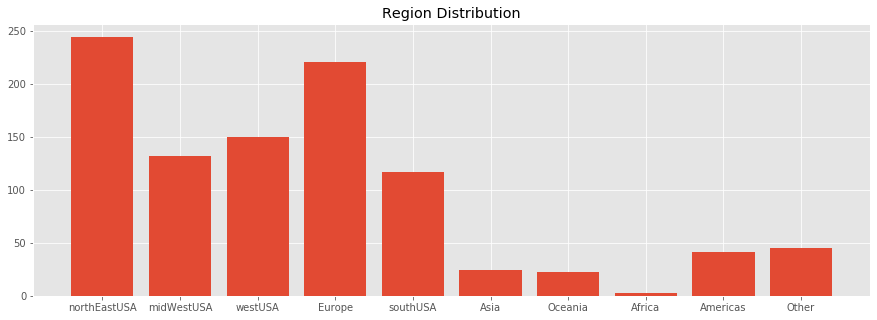

In [138]:
regionList = df['region'].tolist()
countedRegion = Counter(regionList)

plt.figure(figsize=(15,5))
plt.bar(range(len(countedRegion)), list(countedRegion.values()), align='center')
plt.xticks(range(len(countedRegion)), list(countedRegion.keys()))
plt.title('Region Distribution')
plt.show()

As we can see in the graph above, we have a large representation of popular celebrities from North East USA and Europe.

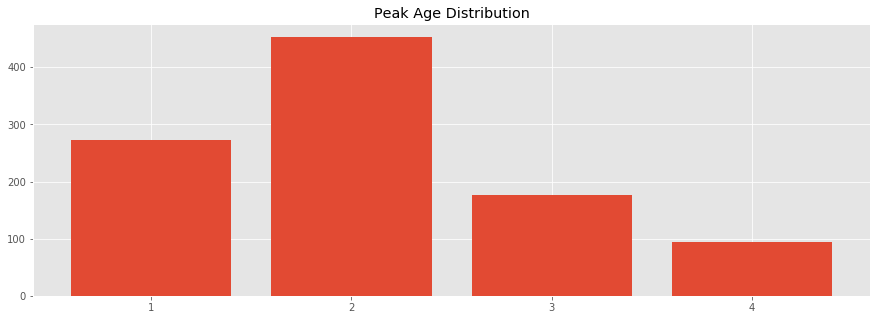

In [137]:
ageList = df['peakAge'].tolist()
countedAge = Counter(ageList)
countedAge = dict(sorted(countedAge.items()))

plt.figure(figsize=(15,5))
plt.bar(range(len(countedAge)), list(countedAge.values()), align='center')
plt.xticks(range(len(countedAge)), list(countedAge.keys()))
plt.title('Peak Age Distribution')
plt.show()

The graph above suggests that most of the celebrities peak at younger ages, mostly between the ages of 30 and 45.

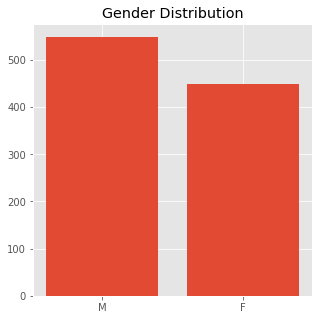

In [136]:
genderList = df['gender'].tolist()
countedGender = Counter(genderList)

plt.figure(figsize=(5,5))
plt.bar(range(len(countedGender)), list(countedGender.values()), align='center')
plt.xticks(range(len(countedGender)), list(countedGender.keys()))
plt.title('Gender Distribution')
plt.show()

We can see that we have relatively equal representation of celebrities from both genders, with a slight dominance of male actors in the dataset. 

## Building a Model

Now we will build our prediction model based on the information in the processed dataframe. We will be predicting the likelihood of a celebrity being featured in a certain genre.

Since we have split features into groups, we will be using categorical predictors. For each feature (region, gender, or peak age), we count the number of celebrities in the genre for each category of that feature. However, since some celebrities have done more works in certain genres than others, we want to weight the number of works in the genre for each category. So rather than counting the number of celebrities, we count the number of works in the genre corresponding to a celebrity within that category of the feature.

Although we weigh the celebrities by the number of their works in that genre, this classifier is still a binary classifier predicting whether or not a celebrity would be featured in a genre.

We compute the partial log likelihood for each feature.

In [94]:
class CategoricalPredictor:
    def __init__(self, k):
        self.k = k
        self.p = dict()

    def fit(self, x, y, alpha=1.):
        featuresDict = dict()
        classes = {0, 1}
        counts = dict()
        counts[0] = 0
        counts[1] = 0
        
        for i, v in x.items():
            if y[i] == 0:
                counts[0] += 1
            else:
                counts[1] += y[i]
            
            if v in featuresDict:      
                if y[i] == 0:
                    featuresDict[v][0] += 1
                else:
                    featuresDict[v][1] += y[i]
            else:
                featuresDict[v] = dict()
                featuresDict[v][0] = 1
                featuresDict[v][1] = y[i]
                

        for feature in featuresDict:
            self.p[feature] = []
            for c in classes:
                n = 0
                if c in featuresDict[feature]:
                    n = featuresDict[feature][c]
                
                self.p[feature].append((n + alpha)/(counts[c] + (len(featuresDict) * alpha)))
        for f in self.p:
            self.p[f] = np.asarray(self.p[f])
        return self

    def partial_log_likelihood(self, x):
        res = []
        if not isinstance(x, list):
            x = x.tolist()
        for i in range(0, self.k):
            res.append([])
            for j in range(0, len(x)):
                f = x[j]
                res[i].append(np.log(self.p[f][i]))
        return np.asarray(res)

def categorical_pred(k):
    return CategoricalPredictor(k)



Below, we split our dataset into training and test sets.

In [181]:
msk = np.random.rand(len(df)) < 0.8

train = df[msk]
test = df[~msk]


Below are examples of the partial log likelihoods of different features for the action genre.

In [188]:
"""
partial log likelihood of peak age.
"""
p = categorical_pred(2)
data = train['peakAge']
labels = train['action']
p.fit(data, labels)
pll = p.partial_log_likelihood([1,2,3,4])
print(pll)

[[-1.42176875 -0.8464046  -1.56486959 -2.09293702]
 [-1.33215905 -0.65631762 -1.88810511 -2.71845342]]


In [189]:
"""
partial log likelihood of region
"""
data = df['region']
labels = df['action']
p.fit(data, labels)

pll = p.partial_log_likelihood(['Americas','Asia','Europe','Africa','Oceania','midWestUSA','southUSA','northEastUSA','westUSA'])
print(pll)

[[-3.26023101 -3.95337819 -1.59672588 -5.45745559 -3.7527075  -1.81986943
  -2.19935905 -1.27540545 -1.94591015]
 [-2.9413382  -3.02301623 -1.4840921  -5.08140436 -3.6150673  -2.39582702
  -2.02113357 -1.65822808 -1.82973872]]


In [192]:
"""
partial log likelihood of gender
"""
p = categorical_pred(2)
data = train['gender']
labels = train['action']
p.fit(data, labels)
pll = p.partial_log_likelihood(['M','F'])
print(pll)

[[-0.79223808 -0.60299608]
 [-0.45328298 -1.0093337 ]]


Above, we see that the log likelihood of actors being featured in action films (which is the value at (0,1) in the matrix) is higher than that of actresses (which is the value at (1,1) in the matrix).

Below, we will compute the log likelihood matrix using the categorical predictor.
Our model will be using Naive Bayes as the classifier.

Our constructor computes the log prior for each class (in the genre or not in the genre). It takes in a dataframe, list of features to use (list of strings), and the genre we want to predict on (string). The $\alpha$ is the smoothing factor and we default it to 1.0. We sum the partial log likelihoods with the log prior to get the total log likelihood. To make our final prediction, we take the class with the highest likelihood.

In [163]:
class NaiveBayesClassifier:
    def __init__(self, df, features, genre, alpha=1.):
        prior = dict()
        numRows = 0
        classes = df[genre]
        prior[0] = 0
        prior[1] = 0
        for i,v in classes.items():
            if v != 0:
                prior[1] += 1
            else:
                prior[0] += 1
                
        for v in df:
            if not v in features and v != genre:
                df=df.drop([v],axis = 1)
                
        arr = np.zeros(2)
        ind = 0
        
        for i in prior:
            arr[ind] = (prior[i] + alpha) / (len(df) + alpha * (len(prior)))
            ind += 1
        arr = np.log(arr)
        self.log_prior = arr
        
         
        df = df.reset_index(drop = True)
        ans = dict()
        for i,v in enumerate(df):
            f = CategoricalPredictor(len(arr))
            if v in features or v == genre:
                f.fit(df[v],df[genre])
            else:
                df = df.drop([v],axis = 1)
            ans[v] = f
        del ans[genre]
        
        self.predictor = ans

    def log_likelihood(self, x):
        x = x.reset_index(drop = True)
        methods = self.predictor
        num_c = len(self.log_prior)
        ans = np.zeros(shape = (num_c, len(x)))
        label = np.arange(num_c)
        for v in x:
            if v in methods:
                f = methods[v]
                arr = f.partial_log_likelihood(x[v])
                ans = arr + ans
        
        for i in range(len(ans)):
            ans[i] = ans[i] + self.log_prior[i]
         
        return ans

    def predict(self, x):
        max = 0
        tab = self.log_likelihood(x)
        use = 0
        ans = tab.argmax(axis =0)
        return ans

def naive_bayes(*args, **kwargs):
    return NaiveBayesClassifier(*args, **kwargs)

## Making Predictions

Once we have our model, we will use it to train on our training set and predict on a test set. We can then count the number of predictions that are consistent with the actual data to get an accuracy count, which we divide by the number of data points to get accuracy rate.

In the function `accuracy`, we take in a string list of features and a string genre that we want to predict on and return the accuracy rate that it gives us on the test set. We train on the training set that we split from the original dataset in the previous section. 

In [186]:
def accuracy (features, genre):
    cl = naive_bayes(train, features, genre)
    lp = cl.predict(test)

    action = test[genre].to_dict()
    actionlabel = dict()
    for ind in action:
        if action[ind] != 0:
            actionlabel[ind] = 1
        else:
            actionlabel[ind] = 0
    test[genre] = pd.Series(actionlabel)

    accuracy = test[genre] == lp
    accuracy = accuracy.sum()/len(test)
    return accuracy

In [187]:
allFeatures = ['gender','peakAge', 'region']
genres = ['action', 'comedy', 'romance']
for genre in genres:
    for i in range(1, len(allFeatures) + 1):
        features = combinations(allFeatures, i)
        for feat in features:
            feat = list(feat)
            print((feat, genre))
            print(accuracy(feat, genre))
            print('\n')


(['gender'], 'action')
0.5691489361702128


(['peakAge'], 'action')
0.5425531914893617


(['region'], 'action')


/Users/Cynthia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


0.5797872340425532


(['gender', 'peakAge'], 'action')
0.5957446808510638


(['gender', 'region'], 'action')
0.5797872340425532


(['peakAge', 'region'], 'action')
0.5531914893617021


(['gender', 'peakAge', 'region'], 'action')
0.5478723404255319


(['gender'], 'comedy')
0.6595744680851063


(['peakAge'], 'comedy')
0.6595744680851063


(['region'], 'comedy')
0.648936170212766


(['gender', 'peakAge'], 'comedy')
0.6595744680851063


(['gender', 'region'], 'comedy')
0.601063829787234


(['peakAge', 'region'], 'comedy')
0.648936170212766


(['gender', 'peakAge', 'region'], 'comedy')
0.601063829787234


(['gender'], 'romance')
0.5904255319148937


(['peakAge'], 'romance')
0.5691489361702128


(['region'], 'romance')
0.5691489361702128


(['gender', 'peakAge'], 'romance')
0.5904255319148937


(['gender', 'region'], 'romance')
0.5957446808510638


(['peakAge', 'region'], 'romance')
0.5585106382978723


(['gender', 'peakAge', 'region'], 'romance')
0.5638297872340425




## Conclusion

We began this project by scraping information on 1000 popular celebrities from IMDb, and we processed these information to get the peak age, gender, hometown region, as well as the known work genres of each celebrity. 

From our data visualization, we can see that many popular celebrities peak in between the age of 30 and 45, and North East USA and Europe are home to many of them. We also do see, unsurprisingly, that there are more male than female popular film celebrities.

After processing our data, we built our predictive model using a Naive Bayes classifier with categorical classification.

As shown from the accuracies above of our prediction on different genres with different features, we observe a wide range of agreements. For each genre, we consistently see that when we predict based on only `gender` and `peak age`, we get the highest accuracy rate. This suggests that region has less impact on the genre that the celebrity would be featured in.

However, we see that the accuracies of our predictions never exceed 0.7, meaning that these three features alone are not reliable predictors of genre. Further exploration of this topic will require considerations of more features, such as race, educational background, etc. In addition, IMDb has more comprehensive records of films popular in the USA. Thus future research should gather information from more global databases that would reduce the bias towards America-centered films. But our current project gives us a good idea of prejudice in the U.S. movie industry as it relates to genres.

Our findings in this project are important because media has a huge impact on how we view the world, which means that biases in media can often lead to prejudice in society and reflect the ways in which society views certain groups. As an example from our results, an overrepresentation of young males in action films might suggest to a wider audience that young males are aggressive. Casting more diverse groups within genres can lead to a more accepting and less prejudiced society.